# Temperature Data
This data is included with the git repository. The data is available for NSW, Victoria, SA and Queensland. I've done the discovery for NSW data however we'll use all the states in the model to get a representative result for Australia.

In [1]:
import pandas as pd
import seaborn as sns
from datetime import datetime
df_states = [pd.read_csv(f'~/PycharmProjects/ZZSC9020-Group-M/data/Australia/temperature_{s}.csv') for s in ['nsw', 'vic', 'qld', 'sa']]
df = pd.concat(df_states)
df.columns = [c.lower() for c in df.columns]

# Dates are in mixed format
def parse_date(value: str):
    try:
        result = datetime.strptime(value, '%d/%m/%Y %H:%M')
    except ValueError:
        result = datetime.strptime(value, '%Y-%m-%d %H:%M:%S')
    return result

df['datetime'] = df['datetime'].apply(parse_date)
df

,location,datetime,temperature
0,Bankstown,2010-01-01 00:00:00,23.1
1,Bankstown,2010-01-01 00:01:00,23.1
2,Bankstown,2010-01-01 00:30:00,22.9
3,Bankstown,2010-01-01 00:50:00,22.7
4,Bankstown,2010-01-01 01:00:00,22.6
...,...,...,...
141676,Melbourne (Olympic Park),2021-03-17 22:00:00,18.9
141677,Melbourne (Olympic Park),2021-03-17 22:30:00,17.9
141678,Melbourne (Olympic Park),2021-03-17 23:00:00,17.3
141679,Melbourne (Olympic Park),2021-03-17 23:30:00,16.6


In [2]:
df.groupby('location').count()

,datetime,temperature
location,,
Bankstown,220326,220326
Melbourne (Olympic Park),141681,141681


In [3]:
from datetime import datetime
def trunc_month(value: datetime):
    return datetime(value.year, value.month, 1)

def trunc_quarter(value: datetime):
    return datetime(value.year, (value.month - 1) // 3 * 3 + 1, 1)

df['date'] = df.apply(lambda x: x['datetime'].date(), axis=1)
df['month'] = df['datetime'].apply(trunc_month)
df['quarter'] = df['datetime'].apply(trunc_quarter)
df

,location,datetime,temperature,date,month,quarter
0,Bankstown,2010-01-01 00:00:00,23.1,2010-01-01,2010-01-01,2010-01-01
1,Bankstown,2010-01-01 00:01:00,23.1,2010-01-01,2010-01-01,2010-01-01
2,Bankstown,2010-01-01 00:30:00,22.9,2010-01-01,2010-01-01,2010-01-01
3,Bankstown,2010-01-01 00:50:00,22.7,2010-01-01,2010-01-01,2010-01-01
4,Bankstown,2010-01-01 01:00:00,22.6,2010-01-01,2010-01-01,2010-01-01
...,...,...,...,...,...,...
141676,Melbourne (Olympic Park),2021-03-17 22:00:00,18.9,2021-03-17,2021-03-01,2021-01-01
141677,Melbourne (Olympic Park),2021-03-17 22:30:00,17.9,2021-03-17,2021-03-01,2021-01-01
141678,Melbourne (Olympic Park),2021-03-17 23:00:00,17.3,2021-03-17,2021-03-01,2021-01-01
141679,Melbourne (Olympic Park),2021-03-17 23:30:00,16.6,2021-03-17,2021-03-01,2021-01-01


## Maximum and Minimum
These are the maximum and minimum temperatures in each quarter. These are not representative of the quarter because they represent a single day of extreme temperature.

<Axes: xlabel='quarter', ylabel='temperature'>

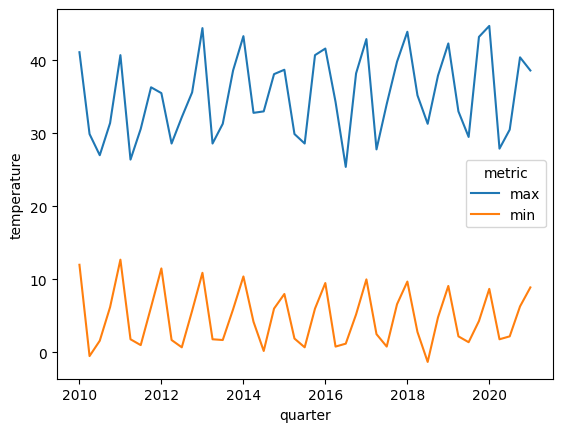

In [4]:
df_max = df[['quarter', 'temperature']].groupby('quarter').max()
df_max['metric'] = 'max'
df_min = df[['quarter', 'temperature']].groupby('quarter').min()
df_min['metric'] = 'min'

df_quarter = pd.concat([df_max, df_min], axis=0)
# df_quarter
sns.lineplot(data=df_quarter, x='quarter', y='temperature', hue='metric')

## Maximum and Minimum Monthly Average
These numbers represent the maximum average monthly temperature for each quarter.
The process for deriving these is:
1. Get the min, max, and mean temperature for each day.
2. Get the monthly averages of the daily min, max and mean.
3. For each quarter:
    - Get the smallest minimum monthly temperature.
    - Get the largest maximum monthly temperature.
    - Get the mean of the mean temperatures of the months.

<Axes: xlabel='quarter', ylabel='temperature'>

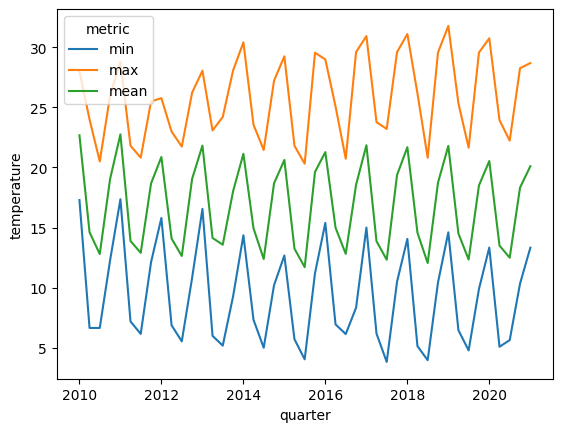

In [5]:
df_day = df.groupby(['date', 'month', 'quarter']).agg({'temperature': ['min', 'max', 'mean']})
# df_day
df_month = df_day.groupby(['month', 'quarter']).mean() # .agg({'min': 'mean', 'max': 'mean'})
df_month.columns = df_month.columns.droplevel()
# df_month
df_quarter = df_month.groupby('quarter').agg({'min': 'min', 'max': 'max', 'mean': 'mean'})
df_quarter = df_quarter.stack().to_frame().reset_index()
df_quarter.columns = ['quarter', 'metric', 'temperature']
# df_max = df[['quarter', 'temperature']].groupby('quarter').max()
# df_max['metric'] = 'max'
# df_min = df[['quarter', 'temperature']].groupby('quarter').min()
# df_min['metric'] = 'min'

# df_quarter = pd.concat([df_max, df_min], axis=0)
df_quarter
sns.lineplot(data=df_quarter, x='quarter', y='temperature', hue='metric')

## Maximum and Minimum Monthly Average by State
These numbers represent the maximum average monthly temperature for each quarter.
The process for deriving these is:
1. Get the min, max, and mean temperature for each day for each location.
2. Get the monthly averages of the daily min, max and mean for each location.
3. For each quarter:
    - Get the smallest minimum monthly temperature for each location.
    - Get the largest maximum monthly temperature for each location.
    - Get the mean of the mean temperatures of the months for each location.

<Axes: xlabel='quarter', ylabel='temperature'>

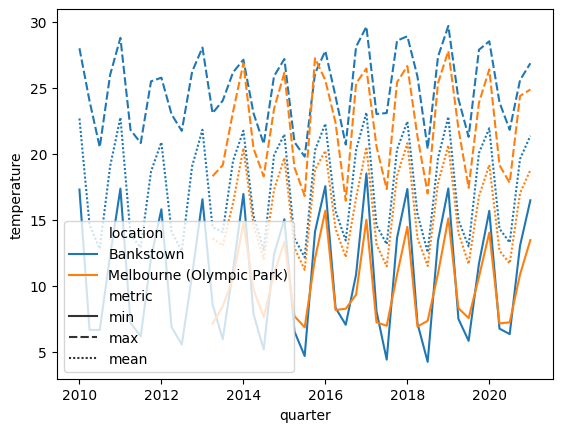

In [7]:
df_day = df.groupby(['location', 'date', 'month', 'quarter']).agg({'temperature': ['min', 'max', 'mean']})
# df_day
df_month = df_day.groupby(['location', 'month', 'quarter']).mean() # .agg({'min': 'mean', 'max': 'mean'})
df_month.columns = df_month.columns.droplevel()
# df_month
# df_max = df[['quarter', 'temperature']].groupby('quarter').max()
# df_max['metric'] = 'max'
# df_min = df[['quarter', 'temperature']].groupby('quarter').min()
# df_min['metric'] = 'min'

# df_quarter = pd.concat([df_max, df_min], axis=0)
df_quarter
sns.lineplot(data=df_quarter, x='quarter', y='temperature', hue='location', style='metric')

<Axes: xlabel='quarter', ylabel='temperature'>

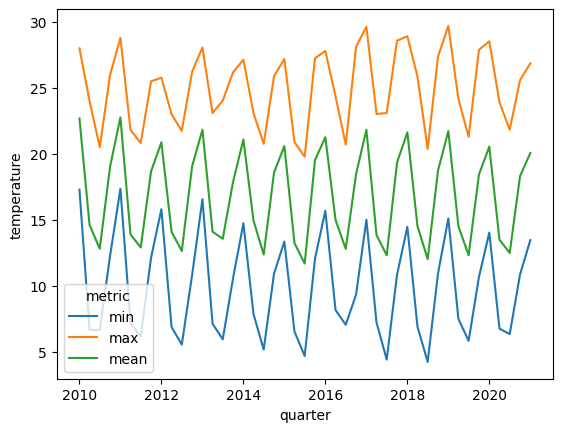

In [9]:
df_combined_quarter = df_month.groupby('quarter').agg({'min': 'min', 'max': 'max', 'mean': 'mean'})
df_combined_quarter = df_combined_quarter.stack().to_frame().reset_index()
df_combined_quarter.columns = ['quarter', 'metric', 'temperature']
df_combined_quarter
sns.lineplot(data=df_combined_quarter, x='quarter', y='temperature', hue='metric')

In [19]:
df_output = df_combined_quarter.pivot(index='quarter', columns='metric', values='temperature').reset_index()
df_output = df_output[['quarter', 'min', 'max']]
df_output.to_csv('temperature.csv', index=False)
df_output

metric,quarter,min,max
0,2010-01-01,17.287097,28.000000
1,2010-04-01,6.640000,24.000000
2,2010-07-01,6.641935,20.500000
3,2010-10-01,12.267742,25.970968
4,2011-01-01,17.354839,28.792857
5,2011-04-01,7.183333,21.810000
6,2011-07-01,6.145161,20.816667
7,2011-10-01,12.112903,25.493333
8,2012-01-01,15.790323,25.770968
9,2012-04-01,6.860000,22.990000
